# Classifying Audio Data using AST and Logistic Regression

<a target="_blank" href="https://colab.research.google.com/github/Sarasi-Sipping-Tea/erdos_dl_recanvo_project/blob/main/sj/P05%20AST%20-%20Classifying%20Audio%20Data%20with%20AST%20and%20Logistic%20Regression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Our work is building upon the results from a 2021 paper titled “Transfer Learning with Real-World Nonverbal Vocalizations from Minimally Speaking Individuals” [https://www.media.mit.edu/publications/transfer-learning-with-real-world-nonverbal-vocalizations-from-minimally-speaking-individuals/] We use the ReCanVo dataset that the original authors had gathered. Each audio clip is labled by caretakers with tags such as "Happy", Dysregulated" , "Hungry" , etc. We consider participant # 05 and we drop labels that has fewer than 30 data points.


<br>

The Goal of this notebook is to check how feasible it is to use AST as a way of extraxting features from the audio data, in order to build a classifier that  predicts the label.

<br>

AST [Audio Spectrogram Transformer] is a purely attention based model developed by Yuan Gong, Yu-An Chung, and James Glass for audio classification. [References: https://arxiv.org/pdf/2104.01778, https://github.com/YuanGongND/ast/tree/master] We use the first five layers of their model to extract features.


## Step 1 : Get the Data from the Recanovo Project

In [ ]:
# Get the Reconvo data from the link https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
# unzip it and put it in the directory: /content/data

! gdown 1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
! tar -xf recanvo.tar.gz
! rm recanvo.tar.gz
! mv recanvo data

Downloading...
From (original): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
From (redirected): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm&confirm=t&uuid=2eee76b7-a698-4804-a043-0b41d0b3b0b8
To: /content/recanvo.tar.gz
100% 1.06G/1.06G [00:19<00:00, 54.7MB/s]


In [ ]:
# Update/install packages to make google colab happy.

! pip install -U scikit-learn
! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.3 MB/s eta 0:00:00


Importing necessary packages and libraries

In [ ]:
import functools
from pathlib import Path

import torchaudio.transforms as T
import math


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    recall_score,
)
from sklearn.model_selection import (
    cross_val_predict,
    StratifiedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#self note: removed the skopt line below so it'll work, if it gives errors
from skopt import BayesSearchCV
import torch
import torchaudio
from tqdm.notebook import tqdm


def to_prob(metric):
    @functools.wraps(metric)
    def metric_that_takes_prob(y_actual, y_pred, sample_weight=None):
        return metric(y_actual, y_pred.argmax(1), sample_weight=sample_weight)

    return metric_that_takes_prob


metrics = {
    "accuracy": to_prob(accuracy_score),
    "balanced_accuracy": to_prob(balanced_accuracy_score),
    "unweighted_f1": to_prob(functools.partial(f1_score, average="macro")),
    "UAR": to_prob(functools.partial(recall_score, average="macro")),
    "logloss": log_loss,
}

The train test split is made so at least one whole session is in the test set


In [ ]:
# data files [importing the new train test split made by Ale from the link: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4]
! gdown 1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4 -O /content/new_train_test.csv

Downloading...
From: https://drive.google.com/uc?id=1zMQzBcjoMXR1FipmrFXJ0rjD7S5IgeT4
To: /content/new_train_test.csv
100% 523k/523k [00:00<00:00, 83.0MB/s]


In [ ]:
#create a dataframe to hold the data
df = pd.read_csv('/content/new_train_test.csv')
#check labels
display(df.Label.value_counts())

,count
Label,
selftalk,1885
frustrated,1536
delighted,1272
dysregulated,704
social,634
request,419
affectionate,129
yes,123
laughter,93


In [ ]:
#Isolate the data for participant #05
df_P05 = df.loc[df.Participant == "P05"]
#check labels
display(df_P05.Label.value_counts())

,count
Label,
selftalk,286
frustrated,283
delighted,235
dysregulated,116
happy,61
help,24
laughter,13
request,6
hunger,4


In [ ]:
#Drop rows with label count < 30
df_P05_dropped = df_P05[df_P05.Label != 'help']
df_P05_dropped = df_P05_dropped[df_P05.Label != 'laughter']
df_P05_dropped = df_P05_dropped[df_P05.Label != 'request']
df_P05_dropped = df_P05_dropped[df_P05.Label != 'hunger']
display(df_P05_dropped.Label.value_counts())

<ipython-input-7-66317e69b8e9>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_P05_dropped = df_P05_dropped[df_P05.Label != 'laughter']
<ipython-input-7-66317e69b8e9>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_P05_dropped = df_P05_dropped[df_P05.Label != 'request']
<ipython-input-7-66317e69b8e9>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_P05_dropped = df_P05_dropped[df_P05.Label != 'hunger']


,count
Label,
selftalk,286
frustrated,283
delighted,235
dysregulated,116
happy,61


A dataframe is isolated to contain only the training data for participant 05

In [ ]:
#create a dataframe that contains training data for participant 05
train_P05 = df_P05_dropped.loc[df_P05_dropped.is_test == 0]

In [ ]:
#temporary cell: checking the dataframe
#print(train_P05)
print(train_P05.Label.value_counts())

Label
frustrated      208
selftalk        199
delighted       146
dysregulated     74
happy            46
Name: count, dtype: int64


## Reformatting & Looping an Example to Fit the Input Format of AST

The sample rate for our audio files is 44.1k. To fit the input format for AST we need it to be in 16k. We also need to convert .wav files to .flac format (a compressed format), so it's in the correct input format for AST. We will also loop the audio to fit the length required to be an inout to AST.

In the following few cells, we isolate a single .wav file from our dataset and perform the reformatting and looping tasks. We will generalize it later to the entire dataset.

In [ ]:
datadir = Path('/content/data/wav')

target_sample_rate = 16000

#choosing an example
filename1 = train_P05.Filename.iloc[0]
waveform1, sample_rate1 = torchaudio.load(datadir / filename1)
resampler = T.Resample(orig_freq=sample_rate1, new_freq=target_sample_rate)
# Apply the resampler
resampled_waveform1 = resampler(waveform1)

#check shape
print(resampled_waveform1.shape)

torch.Size([1, 9136])


In [ ]:
#here we assume the waveform is names "resampled_waveform1"
#make sure to have imported the following
# import math

l = len(resampled_waveform1[0])
multiplier = math.ceil(200000 / l)
#print(multiplier)

# Create a list of the tensor repeated num_repeats times
tensors_list = [resampled_waveform1] * multiplier
# Concatenate them along the new dimension
looped_waveform = torch.cat(tensors_list, dim=1)

# Compute the end index for slicing
end_index = 200000

# Slice the tensor
trimmed_tensor0 = looped_waveform[0][:end_index]
trimmed_tensor = torch.tensor(trimmed_tensor0)
trimmed_looped_waveform1 = trimmed_tensor.unsqueeze(0)

print(trimmed_looped_waveform1.shape)

torch.Size([1, 200000])


<ipython-input-35-a055d26c6fd6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)


In [ ]:
#saving the wave form
#target_sample_rate = 16000 #this was run before

torchaudio.save('output_looped1.flac', trimmed_looped_waveform1, target_sample_rate)
new_wav , new_sam = torchaudio.load('output_looped1.flac')

print(new_wav.shape)

torch.Size([1, 200000])


In [ ]:
from IPython.display import Audio

# Path to the audio file in Google Drive
audio_path = '/content/output_looped1.flac'

# Create an Audio object
audio = Audio(audio_path)

# Display the audio player
display(audio)

We will visualize thet features extracted for this example in a later section.

In the next section we will import AST and then automate the above process for each datapoint in our dataset, feed them to AST to generate features

Self Note: We may need to loop the audio files to get it to be a certain length. But we will run a trial run without it first.


# Step 2 : Import AST

Here we experiment with extracting features using AST that was introduced in  https://github.com/YuanGongND/ast [ADD A PROPER CITATION]

In [ ]:
#more imports

import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd /content/ast/

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '/content/ast/pretrained_models'
if os.path.exists('/content/ast/pretrained_models') == False:
  os.mkdir('/content/ast/pretrained_models')
import timm
from torch.cuda.amp import autocast
import IPython

Running in Colab.
Cloning into 'ast'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 649 (delta 172), reused 159 (delta 159), pack-reused 440 (from 1)
Receiving objects: 100% (649/649), 2.41 MiB | 5.73 MiB/s, done.
Resolving deltas: 100% (360/360), done.
/content/ast
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=aa6b4323aa7587db77f430de03e2d3efb9fbd45d156fac65d26b1b1d48ee22bd
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


Create AST model and load AudioSet pretrained weights.

In [ ]:
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank

#REMOVING SINCE WE WILL NOT USE THEIR LABELS
#def load_label(label_csv):
    #with open(label_csv, 'r') as f:
        #reader = csv.reader(f, delimiter=',')
        #lines = list(reader)
    #labels = []
    #ids = []  ## Each label has a unique id such as "/m/068hy"
    #for i1 in range(1, len(lines)):
        #id = lines[i1][1]
        #label = lines[i1][2]
        #ids.append(id)
        #labels.append(label)
    #return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('/content/ast/pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='/content/ast/pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '/content/ast/pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location='cuda')
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("cuda:0"))
audio_model.eval()

#REMOVING SINCE WE WILL NOT USE THEIR LABELS
## Load the AudioSet label set
#label_csv = '/content/ast/egs/audioset/data/class_labels_indices.csv'       ## label and indices for audioset data
#labels = load_label(label_csv)

/content/ast/src/models/ast_models.py:164: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: /content/ast/pretrained_models/audio_mdl.pth


<ipython-input-21-451c6cb809a9>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cuda')


DataParallel(
  (module): ASTModelVis(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): 

Here we experiment with feature extraction using AST for the example we picked in the previous section

In [ ]:
# Use the make_features function to build spectrograoms and then perform some initial feature extraction process on it
feats1 = make_features('/content/output_looped1.flac', mel_bins=128)

feats1_data = feats1.expand(1, input_tdim, 128)           # reshape the feature
feats1_data = feats1_data.to(torch.device("cuda:0"))

with torch.no_grad():
  with autocast():
    att_list1 = audio_model.module.forward_visualization(feats1_data)
#REWRITE THE FOLLOWING TO NOT PRINT, BUT OUTPUT THE FEATURES IN THE DESIRED FORMAT
#print(att_list[11])


<ipython-input-38-a29ff1143657>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [ ]:
# Tempporary Cell
print(feats1.shape)

torch.Size([1024, 128])


We average over a specific dimension to simplify the tensor. We will use both averaging techniques seperately to simplify our features.


In [ ]:
# Feature candidate 1
feats1_mean_axis0 = feats1.mean(dim=0)
print(feats1_mean_axis0.shape)

torch.Size([128])


In [ ]:
# # Feature candidate 1
feats1_mean_axis1 = feats1.mean(dim=1)
print(feats1_mean_axis1.shape)

torch.Size([1024])


## Visualize the features generated by the example

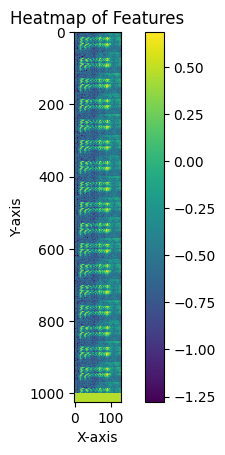

In [ ]:
# Visualize the initial features that were extracted.

# Create a heatmap
plt.imshow(feats1, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Heatmap of Features')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

<ipython-input-41-2f47c2be0b2b>:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


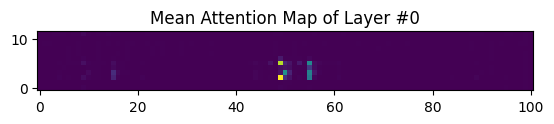

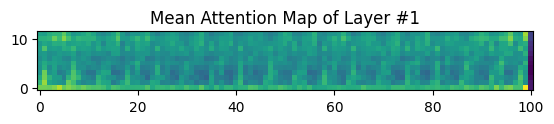

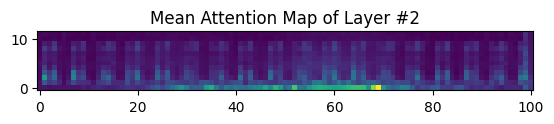

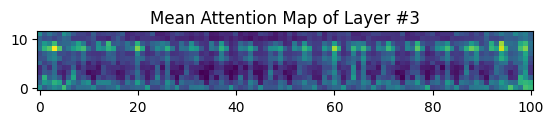

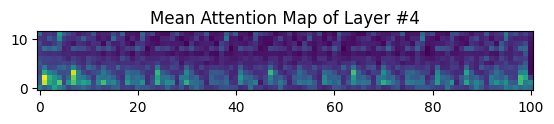

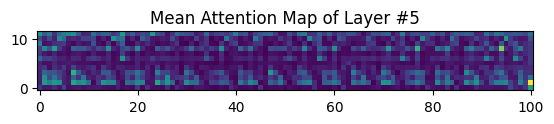

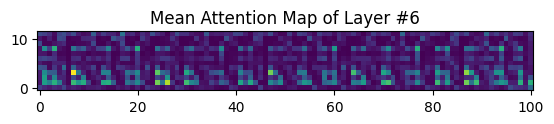

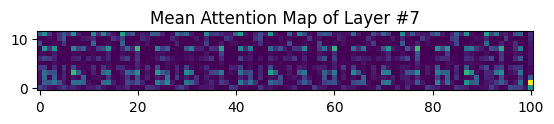

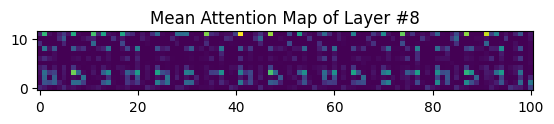

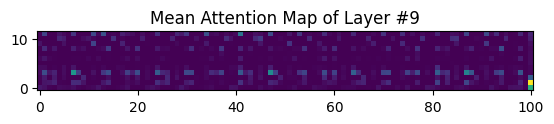

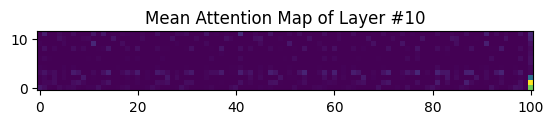

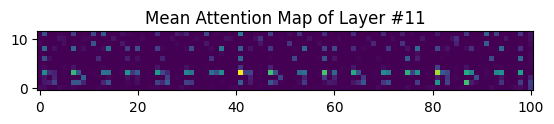

In [ ]:
# Here at att_list is built to hold the results of further layers. And they are visualized as heat maps

with torch.no_grad():
  with autocast():
    att_list1 = audio_model.module.forward_visualization(feats1_data)
for i in range(len(att_list1)):
  att_list1[i] = att_list1[i].data.cpu().numpy()
  att_list1[i] = np.mean(att_list1[i][0], axis=0)
  att_list1[i] = np.mean(att_list1[i][0:2], axis=0)
  att_list1[i] = att_list1[i][2:].reshape(12, 101)
  plt.imshow(att_list1[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

DELETE THE FOLLOWING 4 CELLS AFTER RUNNING ONCE

In [ ]:
# potential feature candidate 2 (1 being feats)
print(att_list1[5].shape)

(12, 101)


In [ ]:
print(att_list1[5])

[[0.00030287 0.00014918 0.00016719 ... 0.00016664 0.0003028  0.0010373 ]
 [0.00017616 0.00101034 0.00082062 ... 0.00080865 0.00037174 0.00181688]
 [0.00019554 0.00092696 0.00044077 ... 0.00065223 0.00029439 0.00070798]
 ...
 [0.00079239 0.00011638 0.00016138 ... 0.00018588 0.00024905 0.00032885]
 [0.00044054 0.00019492 0.00043883 ... 0.00014826 0.00016291 0.00047631]
 [0.00095518 0.00055863 0.00071284 ... 0.00050029 0.0004309  0.00069304]]


In [ ]:
att_5_trial = torch.from_numpy(att_list1[5])
print(att_5_trial.shape)

torch.Size([12, 101])


In [ ]:
att_list5_flat = torch.flatten(att_5_trial)
print(att_list5_flat.shape)

torch.Size([1212])


Here we try the same visualization for a different example after looping the audio

In [ ]:
#choosing another example
filename2 = train_P05.Filename.iloc[5]
waveform2, sample_rate2 = torchaudio.load(datadir / filename2)
resampler = T.Resample(orig_freq=sample_rate2, new_freq=target_sample_rate)
# Apply the resampler
resampled_waveform2 = resampler(waveform2)

l = len(resampled_waveform2[0]) #take the length of the waveform
multiplier = math.ceil(200000 / l) #create a multiplier
tensors_list = [resampled_waveform2] * multiplier  # Create a list of the tensor repeated num_repeats times
looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
end_index = 200000 #the length that fit the input format for AST
trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
trimmed_tensor = torch.tensor(trimmed_tensor0)
trimmed_looped_waveform2 = trimmed_tensor.unsqueeze(0)
  #Save flac file
torchaudio.save('output_looped2.flac', trimmed_looped_waveform2, target_sample_rate)
#new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed


<ipython-input-54-5ec94630d3ef>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)


In [ ]:
#check the sound
IPython.display.Audio('/content/ast/output_looped2.flac')

In [ ]:
# Use the make_features function to build spectrograoms and then perform some initial feature extraction process on it
feats2 = make_features('output_looped2.flac', mel_bins=128)

feats2_data = feats2.expand(1, input_tdim, 128)           # reshape the feature
feats2_data = feats2_data.to(torch.device("cuda:0"))

with torch.no_grad():
  with autocast():
    att_list2 = audio_model.module.forward_visualization(feats2_data)


<ipython-input-55-6862f39eb6f0>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


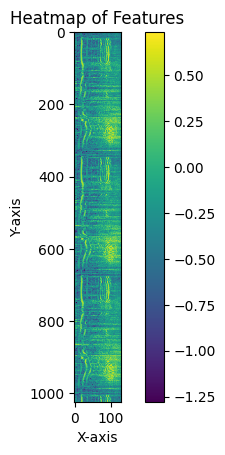

In [ ]:
# Visualize the initial features that were extracted.

# Create a heatmap
plt.imshow(feats2, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Heatmap of Features')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

<ipython-input-57-20387683ce99>:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


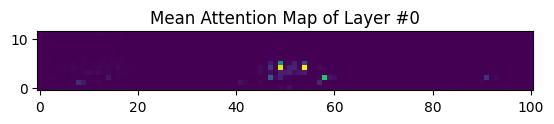

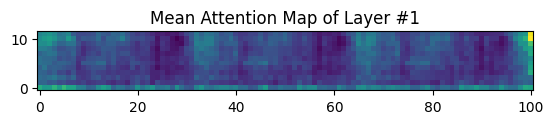

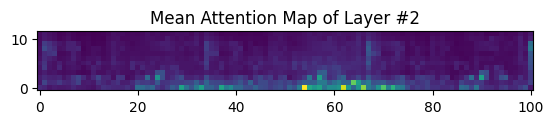

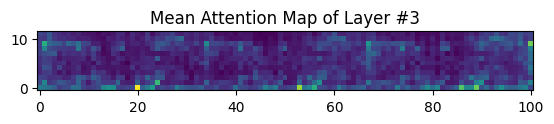

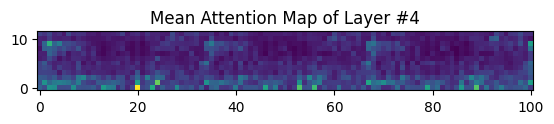

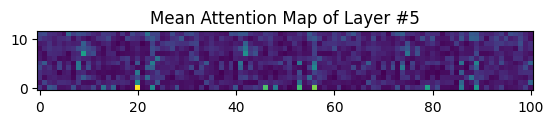

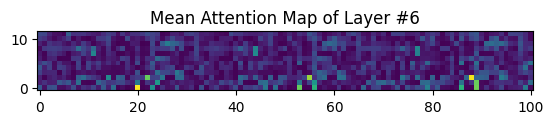

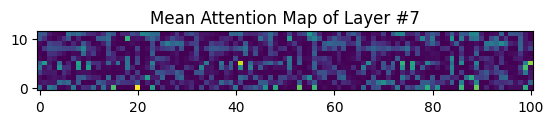

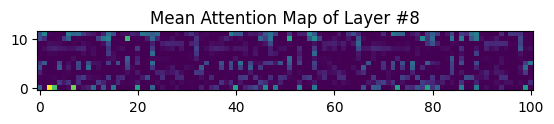

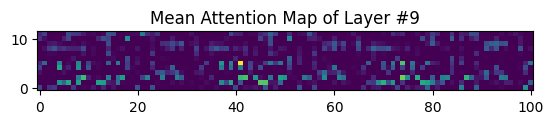

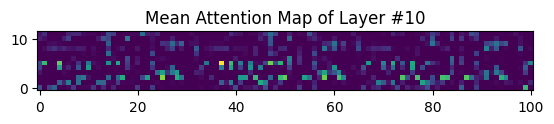

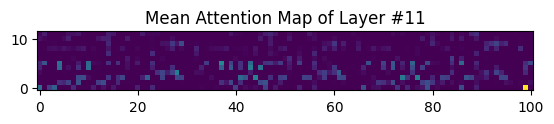

In [ ]:
# Here at att_list is built to hold the results of further layers. And they are visualized as heat maps

with torch.no_grad():
  with autocast():
    att_list2 = audio_model.module.forward_visualization(feats2_data)
for i in range(len(att_list2)):
  att_list2[i] = att_list2[i].data.cpu().numpy()
  att_list2[i] = np.mean(att_list2[i][0], axis=0)
  att_list2[i] = np.mean(att_list2[i][0:2], axis=0)
  att_list2[i] = att_list2[i][2:].reshape(12, 101)
  plt.imshow(att_list2[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

# Step 3 : Extracting Features for All the Data Points in the Training Data for Participant 05



In [ ]:
# these were run earlier
# datadir = Path('/content/data/wav')
# import torchaudio.transforms as T
# target_sample_rate = 16000  # Target sample rate of 16 kHz

feats_list = [] # feature list 0 # Check if this should gather feats_data instead
feats_2_list = [] # feature list 1
Att1_list = [] # feature list 2 ###
Att5_list = [] # feature list 3 ### commented out for now, since we have to figure out a feasible size compression tactic first

for filename in train_P05.Filename:
  waveform, sample_rate = torchaudio.load(datadir / filename)
  #resample
  resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
  resampled_waveform = resampler(waveform) # Apply the resampler
  #loop
  l = len(resampled_waveform[0]) #take the length of the waveform
  multiplier = math.ceil(200000 / l) #create a multiplier
  tensors_list = [resampled_waveform] * multiplier  # Create a list of the tensor repeated num_repeats times
  looped_waveform = torch.cat(tensors_list, dim=1) # Concatenate them along the new dimension
  #Slice
  end_index = 200000 #the length that fit the input format for AST
  trimmed_tensor0 = looped_waveform[0][:end_index] #cutting off the tail
  trimmed_tensor = torch.tensor(trimmed_tensor0)
  trimmed_looped_waveform = trimmed_tensor.unsqueeze(0)
  #Save flac file
  torchaudio.save('output_looped.flac', trimmed_looped_waveform, target_sample_rate)
  #new_wav , new_sam = torchaudio.load('output_looped.flac') #not needed

  # use AST model to make features. Make sure the cell containing the model has been run
  feats = make_features('output_looped.flac', mel_bins=128)

  feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
  feats_data = feats_data.to(torch.device("cuda:0"))

  #make the att_list that contains the results of later layers 1 through 11. We may choose any of these as our features
  with torch.no_grad():
    with autocast():
      att_list = audio_model.module.forward_visualization(feats_data)
  for i in range(len(att_list)):
    att_list[i] = att_list[i].data.cpu().numpy()
    att_list[i] = np.mean(att_list[i][0], axis=0)
    att_list[i] = np.mean(att_list[i][0:2], axis=0)
    att_list[i] = att_list[i][2:].reshape(12, 101)

  att_list1 = torch.from_numpy(att_list[1]) #reshape to get a tensor
  att_list5 = torch.from_numpy(att_list[5]) #reshape to get a tensor

  #turn the feats tensor into 1 dimensional arrays in two different ways
  feats_mean_axis1 = feats.mean(dim=1) #Averaging across the shorter direction so we get a 1024 long array instead of 1024 by 128 tensor
  feats_mean_axis0 = feats.mean(dim=0)
  att_list1_flat = torch.flatten(att_list1) #att_list[1] is two dimensional. here we concatenate rows to get a one dimensional array of length 1212
  att_list5_flat = torch.flatten(att_list5) #same as above

  #gather the features into previously made lists
  feats_list.append(feats_mean_axis1)
  feats_2_list.append(feats_mean_axis0)
  Att1_list.append(att_list1_flat) ###
  Att5_list.append(att_list5_flat) ###

X = torch.stack(feats_list).detach()
X_1 = torch.stack(feats_2_list).detach()
X_2 = torch.stack(Att1_list).detach() ###
X_3 = torch.stack(Att5_list).detach() ###

labels = train_P05.Label.unique()
y = torch.zeros(len(train_P05), dtype=torch.int)
for idx, label in enumerate(labels):
    y[(train_P05.Label == label).values] = idx
print(X.shape, y.shape)


<ipython-input-58-61a1749f365a>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trimmed_tensor = torch.tensor(trimmed_tensor0)
<ipython-input-58-61a1749f365a>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


torch.Size([673, 1024]) torch.Size([673])


In [ ]:
print(X_1.shape, X_2.shape, X_3.shape)

torch.Size([673, 128]) torch.Size([673, 1212]) torch.Size([673, 1212])


In [ ]:
from google.colab import files

# Save the tensor to a file
torch.save(X, 'X.pt')

# Download the file
files.download('X.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(X_1, 'X_1.pt')
torch.save(X_1, 'X_2.pt')
torch.save(X_1, 'X_3.pt')

files.download('X_1.pt')
files.download('X_2.pt')
files.download('X_3.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step 4 : Use Logistic Regression to Check Which Feature is Best

### Feature X = The Output of the Initial Layer (with entries averaged over the dimension with the higher length)

In [ ]:
# seeing which feature makes the most sense
# checking accuracy for feature set 0 : X
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X.reshape(len(X), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.005)])
Best accuracy: 0.3149912203687445


In [ ]:
# Some possible sample weights for training and/or metrics.
# session_weight weights each sample based on sessions, so
# that the total weight of observations in each sesion is
# constant. On top of that, session_and_label_weight assigns
# a label to each weight, which is multiplied by the sesion weight,
# in such a way to make the sum of the weights constant by label.
session_weight = (
    (1 / train_P05.Session.value_counts())
    .clip(None, 0.1)
    .loc[train_P05.Session]
).values
session_and_label_weight = (
    1
    / pd.Series(session_weight, train_P05.index)
    .groupby(train_P05.Label)
    .sum()
).loc[train_P05.Label].values * session_weight

In [ ]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X.reshape(len(X), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.308
balanced_accuracy,0.250
unweighted_f1,0.239
UAR,0.250
logloss,1.546


,session_weight
accuracy,0.292
balanced_accuracy,0.238
unweighted_f1,0.232
UAR,0.238
logloss,1.552


,session_and_label_weight
accuracy,0.238
balanced_accuracy,0.238
unweighted_f1,0.216
UAR,0.238
logloss,1.742


In [ ]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=labels, index=labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,happy,frustrated,dysregulated,selftalk,delighted
actual_label,,,,,
happy,11,10,3,17,5
frustrated,11,93,2,64,38
dysregulated,4,24,2,34,10
selftalk,8,74,2,85,30
delighted,7,60,3,60,16


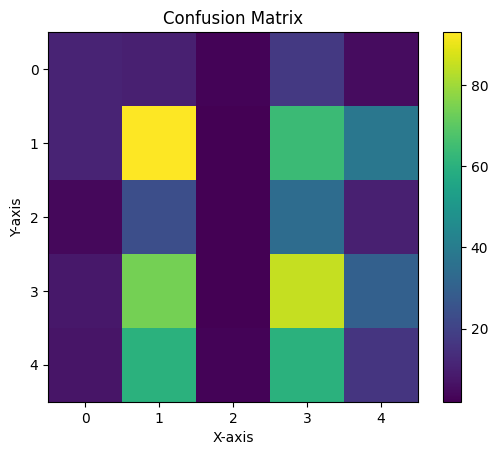

In [ ]:

# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

### Feature X_1 = The Output of the Initial Layer (with entries averaged over the dimension with the lower length)

In [ ]:
# checking accuracy for feature set 1 : X_1
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_1.reshape(len(X_1), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.14347207160679434)])
Best accuracy: 0.6152985074626866


In [ ]:

# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_1.reshape(len(X_1), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight}, ##just checking
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.608
balanced_accuracy,0.547
unweighted_f1,0.547
UAR,0.547
logloss,1.008


,session_weight
accuracy,0.593
balanced_accuracy,0.544
unweighted_f1,0.545
UAR,0.544
logloss,1.056


,session_and_label_weight
accuracy,0.544
balanced_accuracy,0.544
unweighted_f1,0.529
UAR,0.544
logloss,1.196


In [ ]:

# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=labels, index=labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,happy,frustrated,dysregulated,selftalk,delighted
actual_label,,,,,
happy,29,0,2,4,11
frustrated,0,159,18,14,17
dysregulated,8,29,14,12,11
selftalk,2,10,6,147,34
delighted,5,22,5,54,60


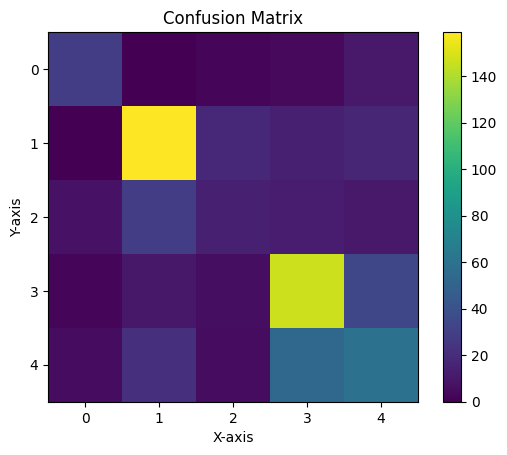

In [ ]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

### Feature X_2 = The Output of the 1st Attention Layer

In [ ]:

# checking accuracy for feature set 2 : X_2
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_2.reshape(len(X_2), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.1713123734640013)])
Best accuracy: 0.6182835820895523


In [ ]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_2.reshape(len(X_2), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)


,no_weight
accuracy,0.606
balanced_accuracy,0.547
unweighted_f1,0.548
UAR,0.547
logloss,1.008


,session_weight
accuracy,0.591
balanced_accuracy,0.544
unweighted_f1,0.545
UAR,0.544
logloss,1.057


,session_and_label_weight
accuracy,0.544
balanced_accuracy,0.544
unweighted_f1,0.530
UAR,0.544
logloss,1.197


In [ ]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=labels, index=labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,happy,frustrated,dysregulated,selftalk,delighted
actual_label,,,,,
happy,29,0,2,5,10
frustrated,0,159,18,14,17
dysregulated,8,28,15,14,9
selftalk,2,9,7,146,35
delighted,5,22,5,55,59


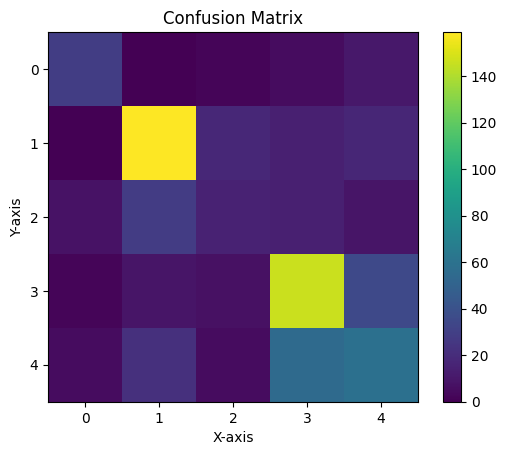

In [ ]:

# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

### Feature X_3 = The Output of the 5th Attention Layer

In [ ]:

# checking accuracy for feature set 3 : X_3
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X_3.reshape(len(X_3), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.16460942225047925)])
Best accuracy: 0.6168129938542581


In [ ]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)
oos_pred_prob = cross_val_predict(
    est,
    X_3.reshape(len(X_3), -1), #why was this reshaping done?
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    #params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)


,no_weight
accuracy,0.605
balanced_accuracy,0.544
unweighted_f1,0.545
UAR,0.544
logloss,1.008


,session_weight
accuracy,0.591
balanced_accuracy,0.543
unweighted_f1,0.544
UAR,0.543
logloss,1.057


,session_and_label_weight
accuracy,0.543
balanced_accuracy,0.543
unweighted_f1,0.528
UAR,0.543
logloss,1.197


In [ ]:
# Confusion matrix

conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=labels, index=labels
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,happy,frustrated,dysregulated,selftalk,delighted
actual_label,,,,,
happy,29,0,2,5,10
frustrated,0,159,18,14,17
dysregulated,8,29,14,13,10
selftalk,2,9,7,146,35
delighted,5,22,5,55,59


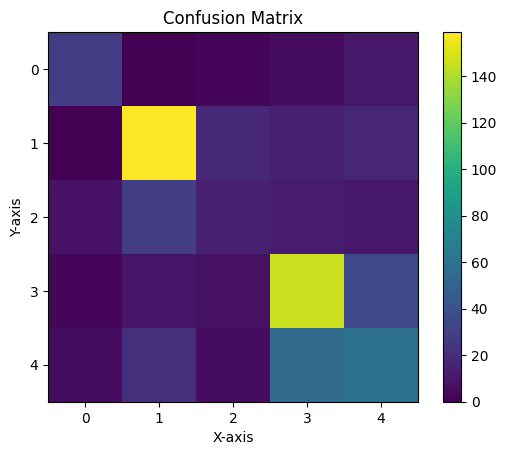

In [ ]:
# Create a heatmap
plt.imshow(conf_matrix_df, cmap='viridis', interpolation='nearest')

# Add a colorbar to show the scale
plt.colorbar()

# Add labels and title if desired
plt.title('Confusion Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Show the plot
plt.show()

# Conclusions

It seems that the feature X_1 has the highest accuracy level. But all three X_1, X_2, X_3 has decent accuracy levels (~0.6). X did not perform well. (Will not consider X as a feature for other participants.)

</br>

When used each of the later three features, this technique seems to be fairly good at recognizing the labels "frustrated" and "selftalk". The accuracy in recognizing those two labels is not surprising since those two were the ones with the highest datapoints for participant 05.

</br>

With a dataset that has a higher count of datapoints, features extracted from AST could potentially prove to be much more useful. However, the fact that the usage of the initial layer vs the 5th attention layer did not show that much of a difference in performance (in fact the earlier layer performed slightly better) suggests that at least in this example, the added "deepness" did not accomplish that much more. That being said, perhaps a deep network trained specifically on the vocals of one individual could potentially perform better. But for that we would need a much bigger dataset.

</br>

We will try the same technique for participant 01 next.